In [1]:
# Import packages.
import sys
!{sys.executable} -m pip install h5py
import h5py
import xml.etree.ElementTree as ET
import os
import readGalacticusData
import numpy as np
import random
import matplotlib.pyplot as plt

# TODO: Move to appropriate directory here.
cwd = "/central/home/emin/Galacticus/galacticus"
os.chdir(cwd)
print("Done importing and transporting to directory.")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/central/software/python/3.7.0/bin/python3.7 -m pip install --upgrade pip' command.
Done importing and transporting to directory.


In [2]:
def genHaloMassFile(haloMassList, filePath):
    '''
    Writes a .hdf5 halo mass file to filePath given a list of halo masses.
    Weights are set default to 1.0.
    '''
    masses = haloMassList
    weights = [1.0] * len(haloMassList)
    with h5py.File(filePath, 'w') as f:
        f.create_dataset('treeRootMass', data=masses)
        f.create_dataset('treeWeight', data=weights)
        f.close()

def genSampleHaloMassList(start, numHalos):
    '''
    Generates a halo mass list of length numHalos. 
    Starts at 10^(start) and increases in magnitude of 10.
    '''
    masses = np.array([pow, 10.0, _] for _ in range(start, start+numHalos))
    return masses

def getMassResolution(mass):
    '''
    Sample function to get mass resolution based on mass.
    Here it is scaled by 3e-4.
    '''
    return mass*3*pow(10.0, -4)

# Generate parameter file.
def genParameterFile(templateFilePath, outputDirectory, haloMassList, replicationCount, massResolution, redshiftTime, i):
    '''
    Generates a parameter file from a template given the input parameters.
    Returns the new simulation number and parameter file path.
    
    templateFilePath: path containing template parameter file to generate new parameter file from
    outputDirectory: relative directory to store generated input and output files
                     (can be empty string '' if current directory is OK)
    haloMassList: Python list of halos to compute at
    replicationCount: replication count of halo populations
    massResolution: desired mass resolution of simulations.
    '''
    simulationNumber = random.randrange(100000)
    print("STARTING SIMULATION NO. " + str(i))
    print("----------------------------------------------------------------")

    tree = ET.parse(templateFilePath)
    root = tree.getroot()

    inputFilePath = outputDirectory + '/halo_mass_list_' + str(i) + '.hdf5'
    genHaloMassFile(haloMassList, inputFilePath)
    outputFilePath = outputDirectory + '/halo_mass_output_' + str(i) + '.hdf5'
  
    for mergerTree in root.findall('mergerTreeBuildMasses'):
        for replicate in mergerTree.findall('replicationCount'):
            replicate.set('value', str(replicationCount))
        for subTree in mergerTree.findall('mergerTreeBuildMasses'):
            for inputFile in subTree.findall('fileName'):
                inputFile.set('value', inputFilePath)
  
    for mergerTreeMassRes in root.findall('mergerTreeMassResolution'):
        for massRes in mergerTreeMassRes.findall('massResolution'):
            massRes.set('value', str(massResolution))
  
    for outputFile in root.findall('outputFileName'):
        outputFile.set('value', outputFilePath)
    
    for outputTime in root.findall('outputTimes'):
        for redshift in outputTime.findall('redshifts'):
            for value in redshift.findall('value'):
                value.text = str(redshiftTime)
  
    paramFile = outputDirectory + '/parameter_file_' + str(i) + ".xml"
    tree.write(paramFile)
    return i, paramFile
print("Compiled helper functions for running Galacticus.")

Compiled helper functions for running Galacticus.


In [42]:
def convert_Mpc_to_kpc(subHaloData):
    '''
    Converts a list of hdf5 subhalo data from Mpc to kpc.
    '''
    haloMass = readGalacticusData.halo.readHostProperty(subHaloData, 'massBasic') 
    v_min = np.floor(np.log10(haloMass) - 5)
    v_max = np.floor(np.log10(haloMass) - 1)
    masses_virInfall = np.log10(subHaloData.MvirInfall()) 
    arg = np.argsort(subHaloData.Vmax())
    ind = np.sort(masses_virInfall) > v_min
    
    conversion_factor = 1000
    
    x = subHaloData.positionX()[arg][ind][:-1]
    y = subHaloData.positionY()[arg][ind][:-1]
    
    x_kpc = []
    y_kpc = []
    
    for item in x:
        x_kpc.append(conversion_factor * item)
    for item in y:
        y_kpc.append(conversion_factor * item)
    return x_kpc, y_kpc

from matplotlib import cm
def visualize_subhalos(subHaloData, scaleFactor, redshift, i):
    '''
    Visualizes subhalos given a hdf5 set of subhalo data and desired scale factor,
    which affects the size of the individual halos in the visualization.
    '''
    haloMass = readGalacticusData.halo.readHostProperty(subHaloData, 'basicMass')
    print(np.log10(haloMass))
    v_min = np.floor(np.log10(haloMass) - 5)
    v_max = np.floor(np.log10(haloMass) - 1)
    
    masses_virInfall = np.log10(subHaloData.MvirInfall())
    bound_masses = np.log10(subHaloData.Mbound())
    
    plt.figure(figsize=(10,10))#, dpi=500)
    
    arg = np.argsort(subHaloData.Vmax())
    ind = np.sort(masses_virInfall) > v_min

    x_kpc, y_kpc = convert_Mpc_to_kpc(subHaloData)
    x_kpc_shifted = []
    y_kpc_shifted = []
    
    for x_item in x_kpc:
        x_kpc_shifted.append(x_item * (redshift + 1))
    for y_item in y_kpc:
        y_kpc_shifted.append(y_item * (redshift + 1))

    sc = plt.scatter(x_kpc_shifted, y_kpc_shifted,
                 s=scaleFactor*masses_virInfall[arg][ind][:-1],c=bound_masses[arg][ind][:-1],
                 vmin=v_min,vmax=v_max,cmap='Blues')

    # COLORBAR
    cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(r'$\log(M_{\mathrm{bound}}/M_{\mathrm{\odot}})$', rotation=90, fontsize=30)
    cbar.solids.set_rasterized(True)
    cbar.ax.tick_params(labelsize=28)
    
    cir = plt.Circle((0,0),subHaloData.RvirHost*1000*(redshift+1),fill=False,ec='k',ls='dashed',lw=2.0)

    plt.axes().add_artist(cir)
    #plotLim = subHaloData.RvirHost*1000*1.25*(redshift+1)
    plotLim = 700
    plt.xlim(-1*plotLim,plotLim)
    plt.ylim(-1*plotLim,plotLim)

    plt.axes().set_aspect('equal')
    plt.axes().tick_params(labelsize=25)
    plt.xlabel("$x\,[\\rm kpc]$",fontsize=36)
    plt.ylabel("$y\,[\\rm kpc]$",fontsize=36)
    
    redshift_formatted = '{0:.2f}'.format(redshift)
    
    plt.title('redshift: ' + str(redshift_formatted), fontsize=28)

    plt.tight_layout()
    plt.savefig('CASSI/week11/figures/halo_fig_' + str(i) + '.png')
    plt.show()

print("Compiled helper functions for visualizations.")

Compiled helper functions for visualizations.


In [4]:
# Specify parameters here.
templateFilePath='CASSI/week10/parameter_template.xml'
directoryPath = 'CASSI/week10'
haloMassList = np.array([10000000000000.0])
replicationCount = 1
massResolution = getMassResolution(haloMassList[0])

print("Done initializing parameters.")

Done initializing parameters.


13.0


/central/software/python/3.7.0/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


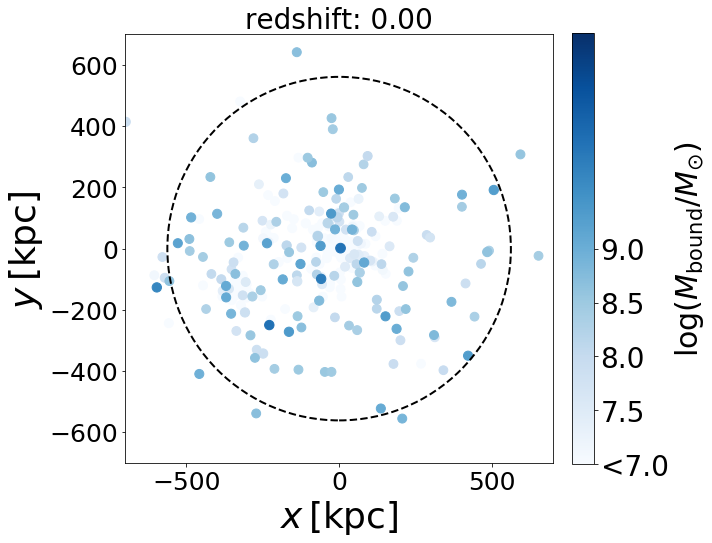

12.998844706700599


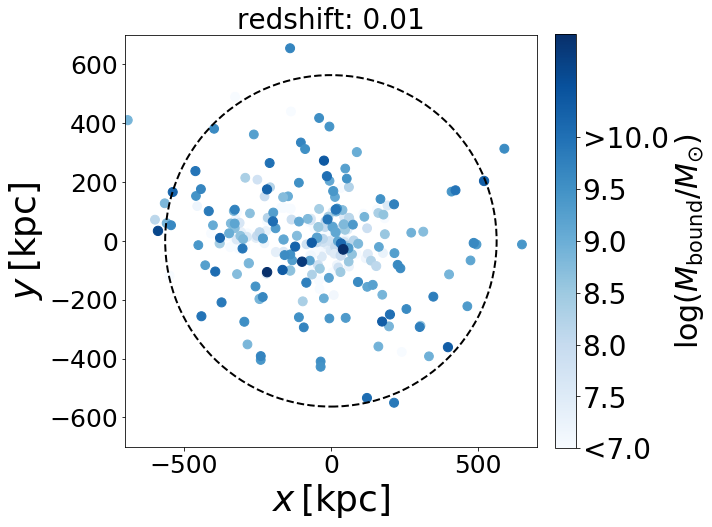

12.997841540235044


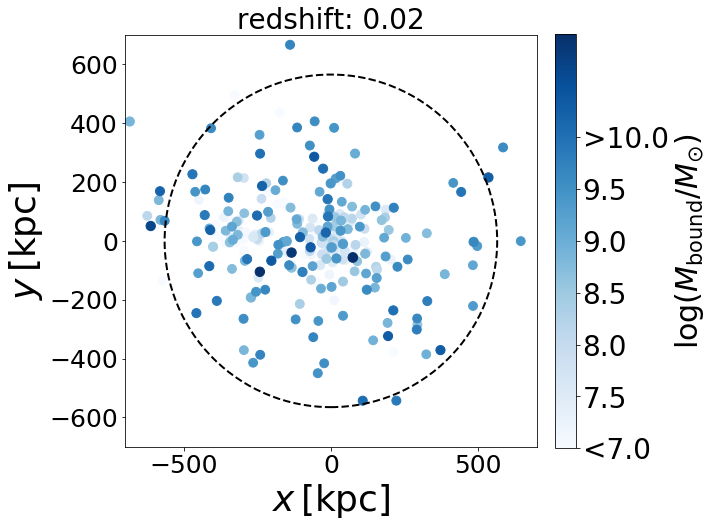

12.866672633894915


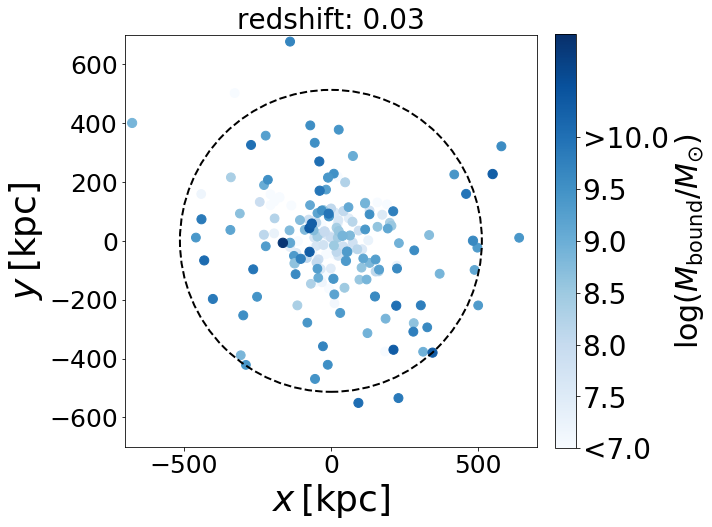

12.865297880734394


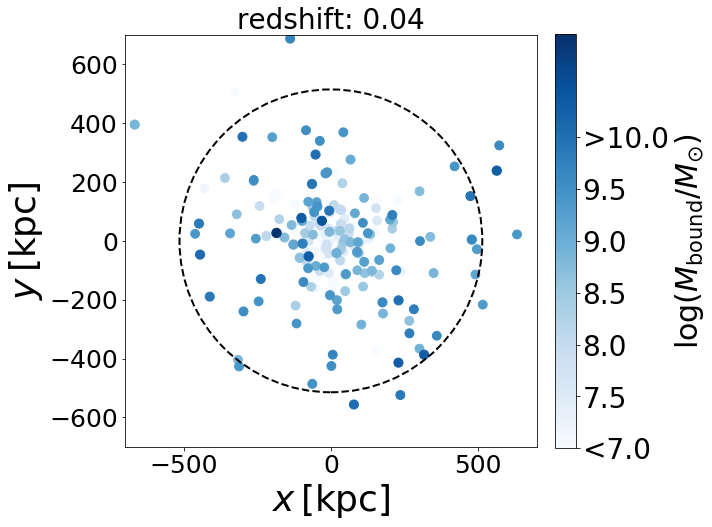

12.861997147013767


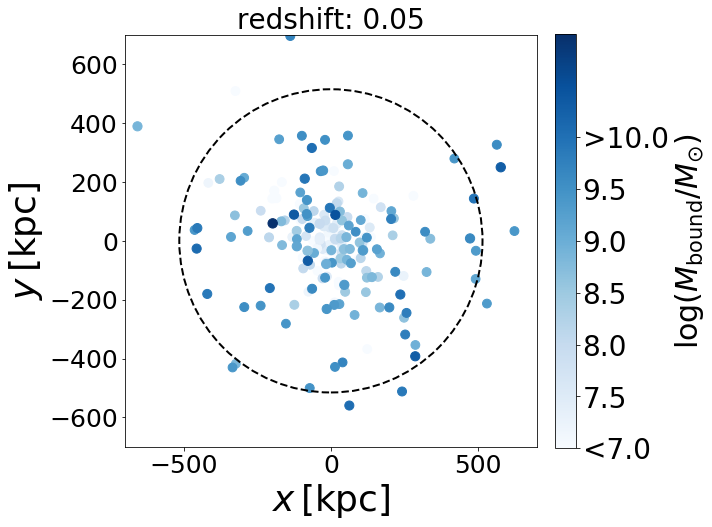

12.860663853884816


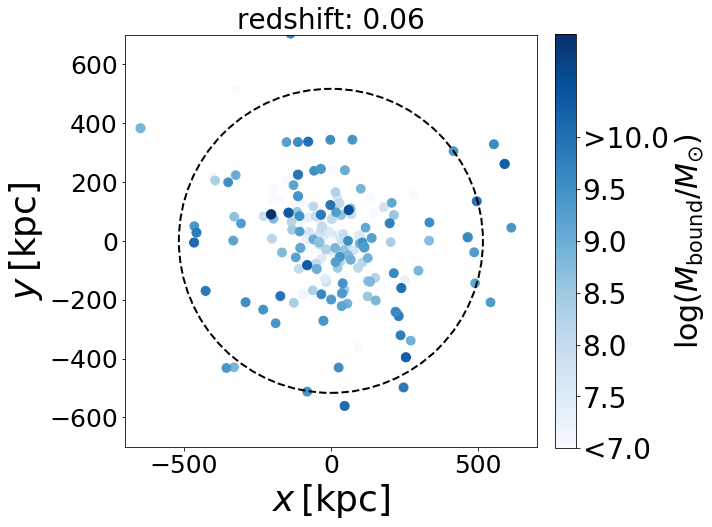

12.85943715952727


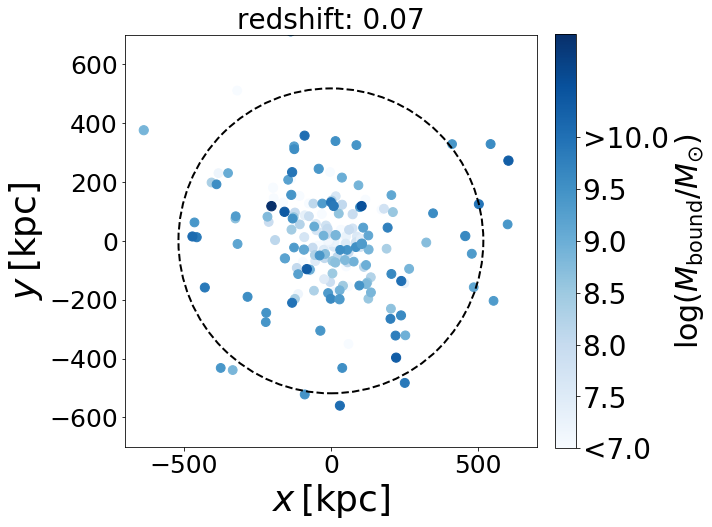

12.858395016110713


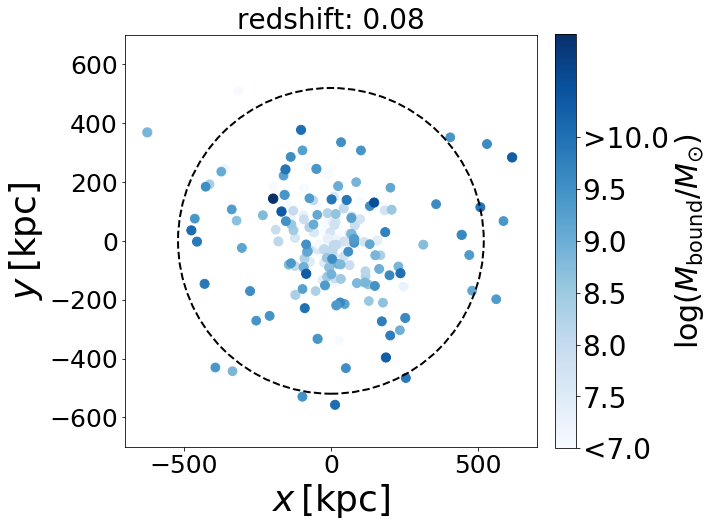

12.857364381420442


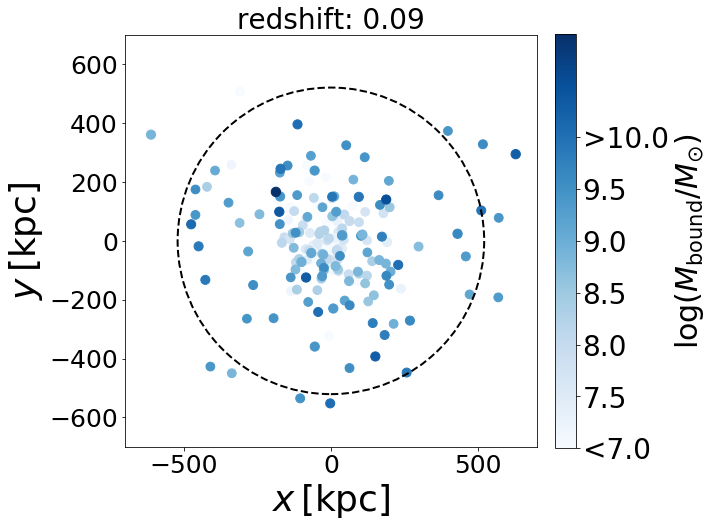

12.856109777934979


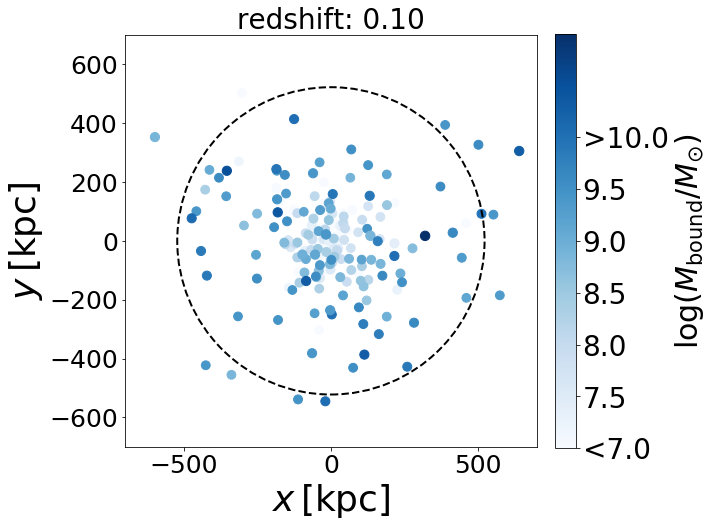

12.855056876000825


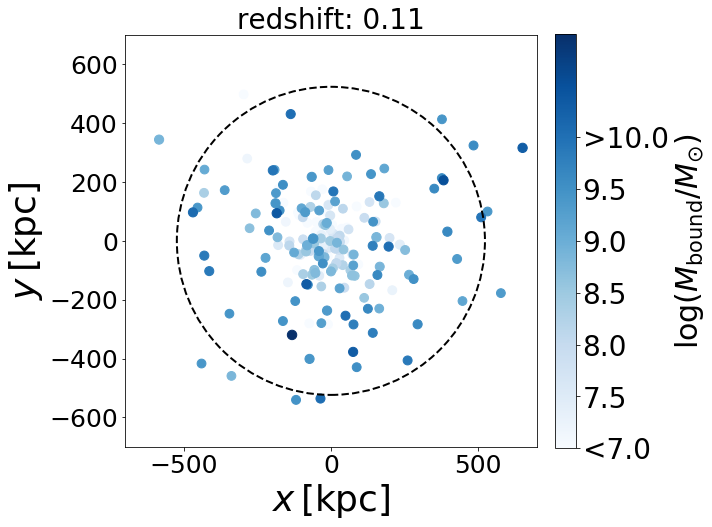

12.851953677166625


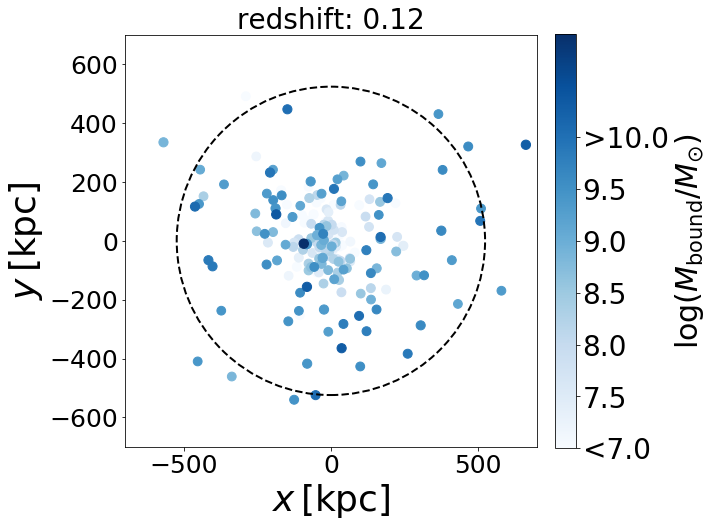

12.850871010352945


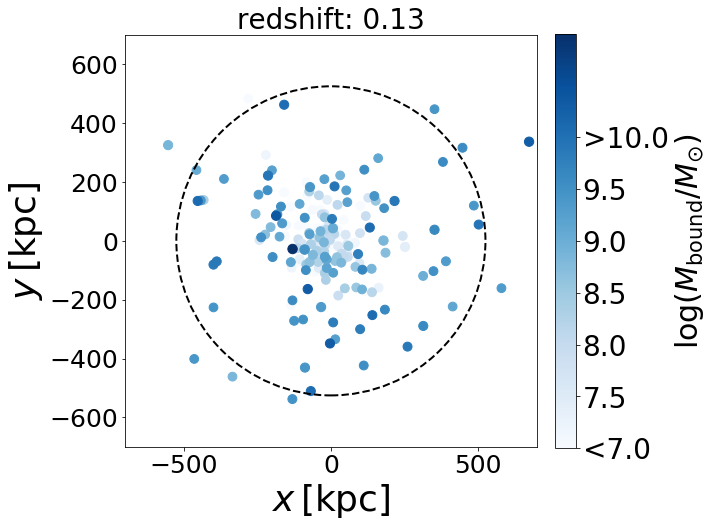

12.849800631596542


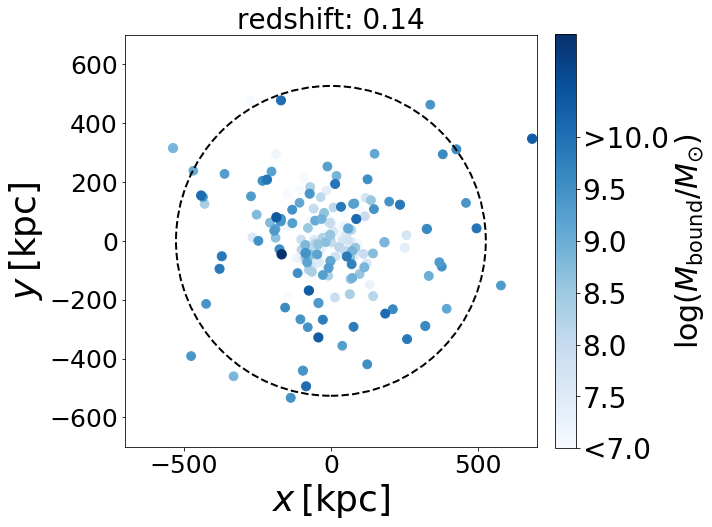

12.848742367285668


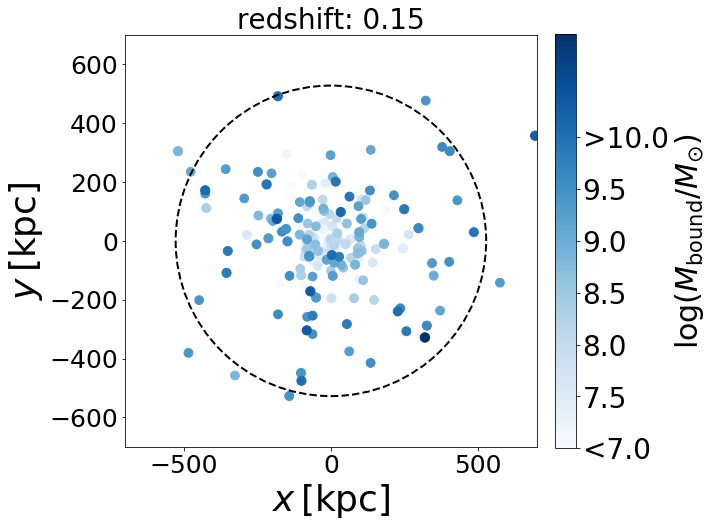

12.840302493786405


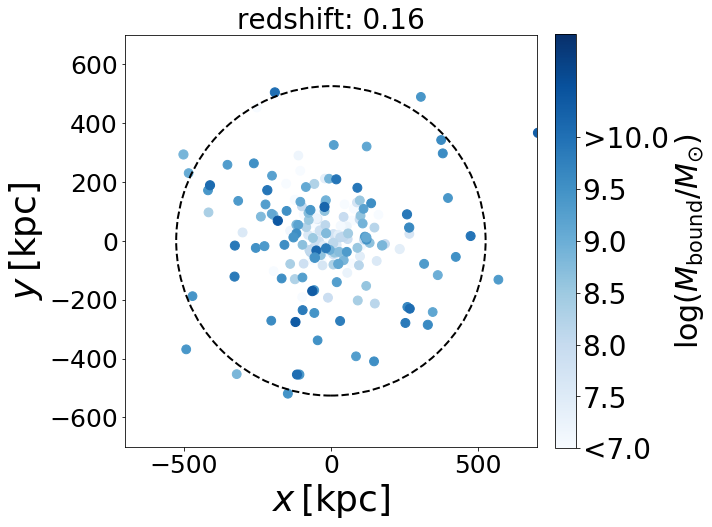

12.839193825797661


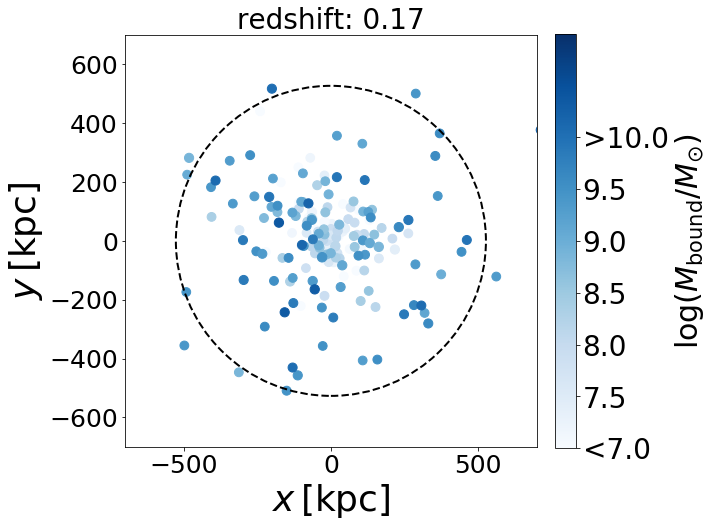

12.838097463074872


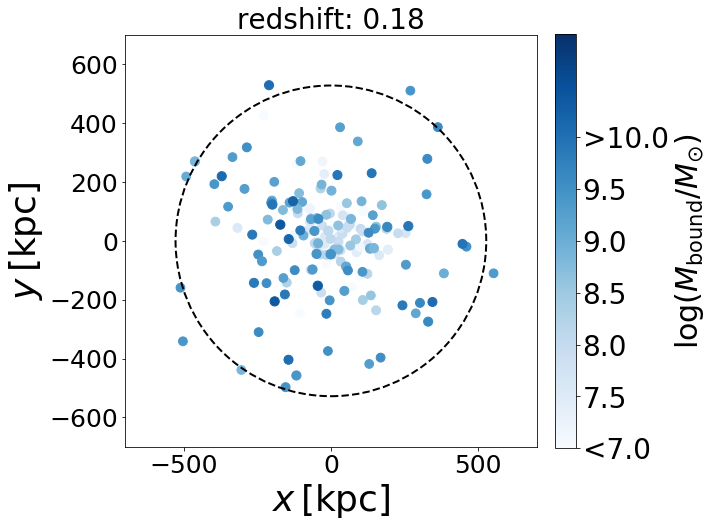

12.836809138025385


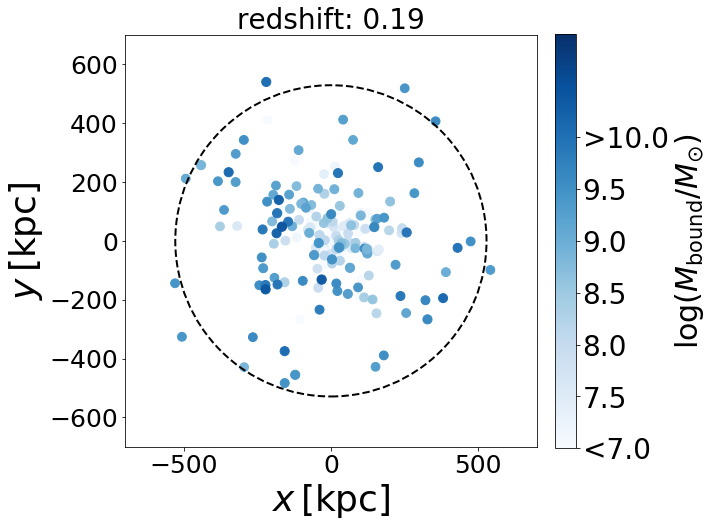

12.834944526689794


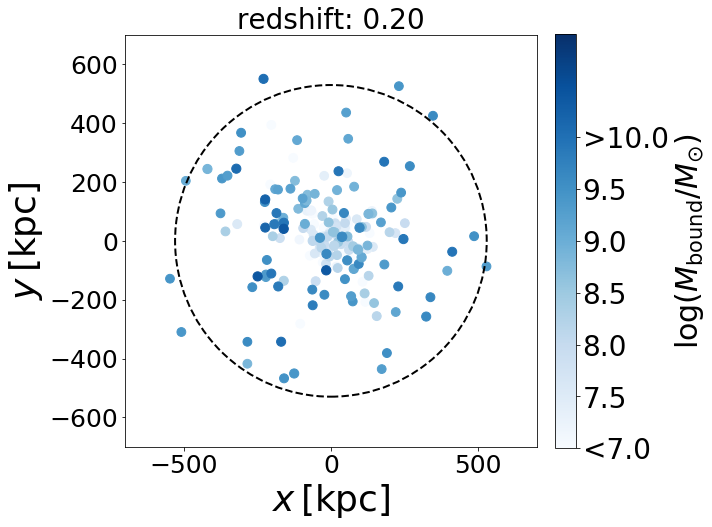

12.833846402543935


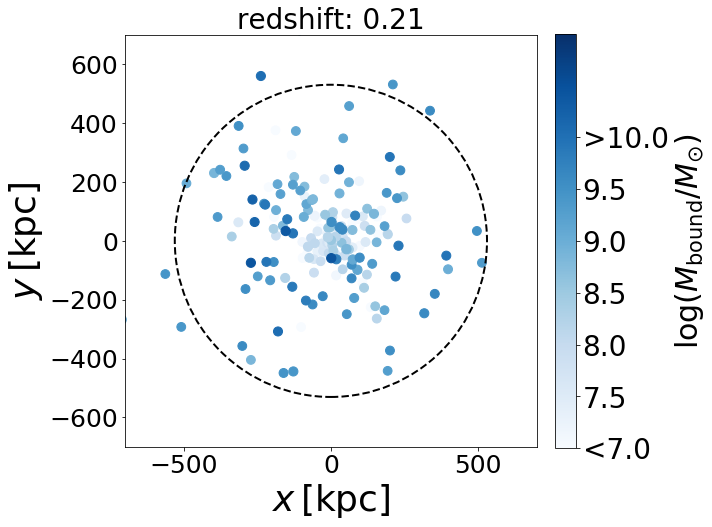

12.832481540298188


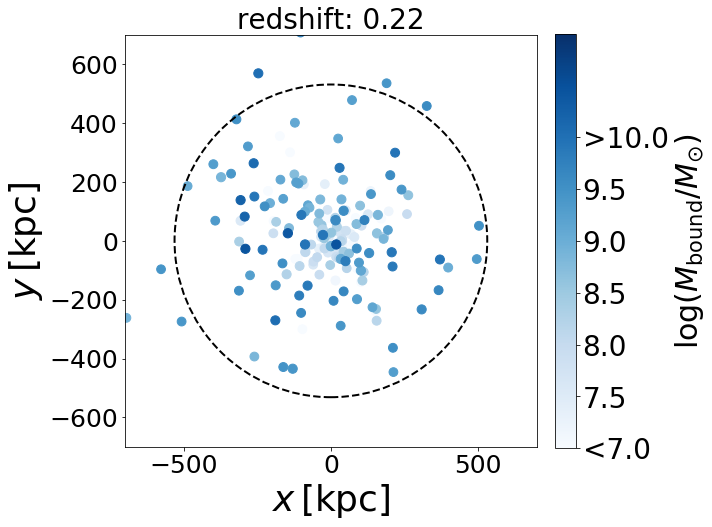

12.831374892281998


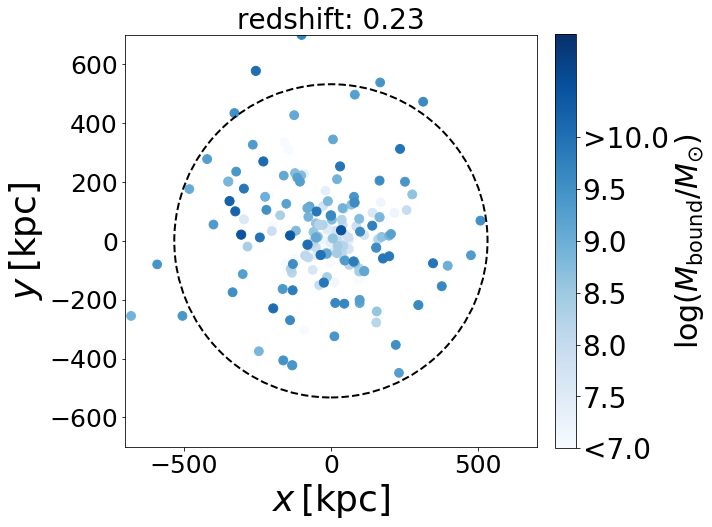

12.829735288787345


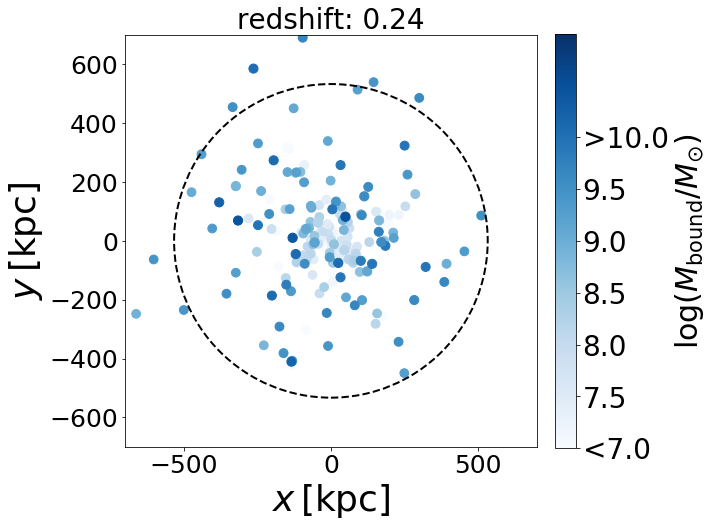

12.827591455988497


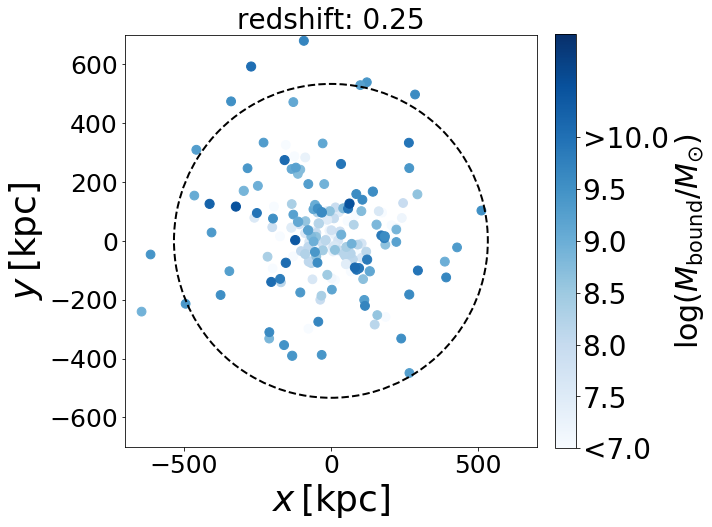

12.82585516697095


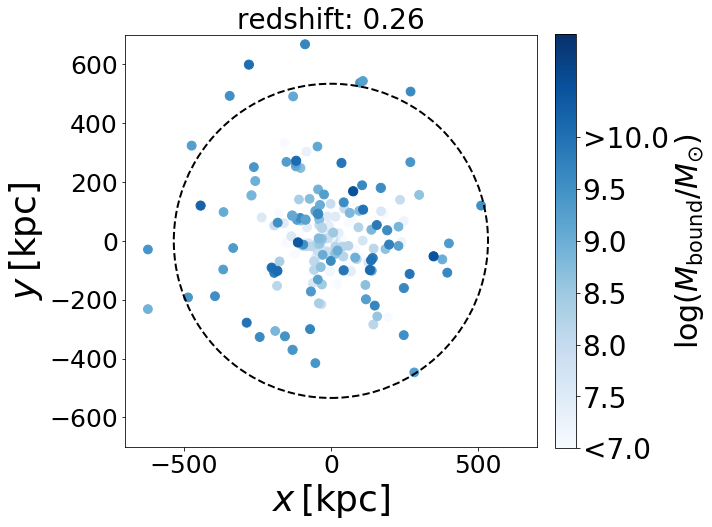

12.824694202776005


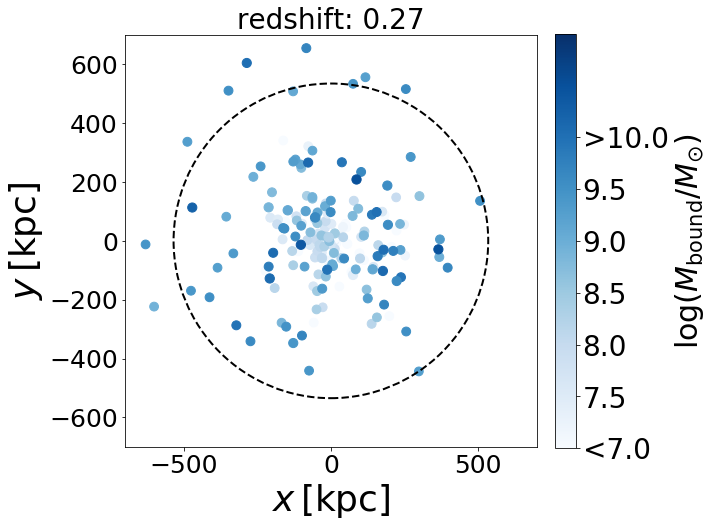

12.823545485584079


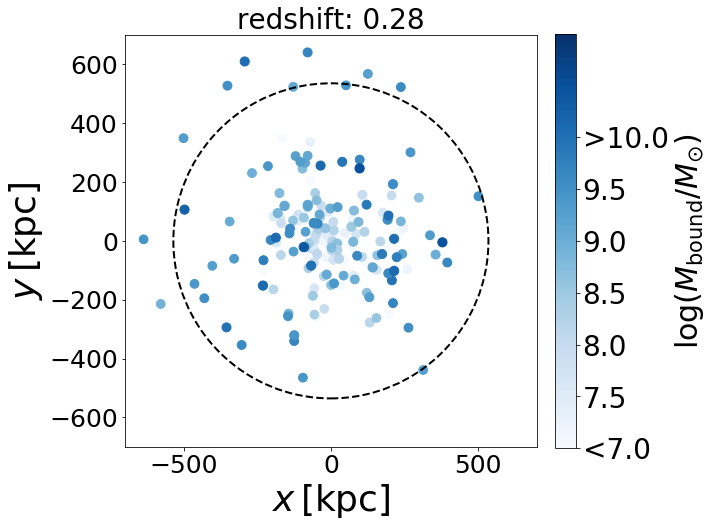

12.822408866879487


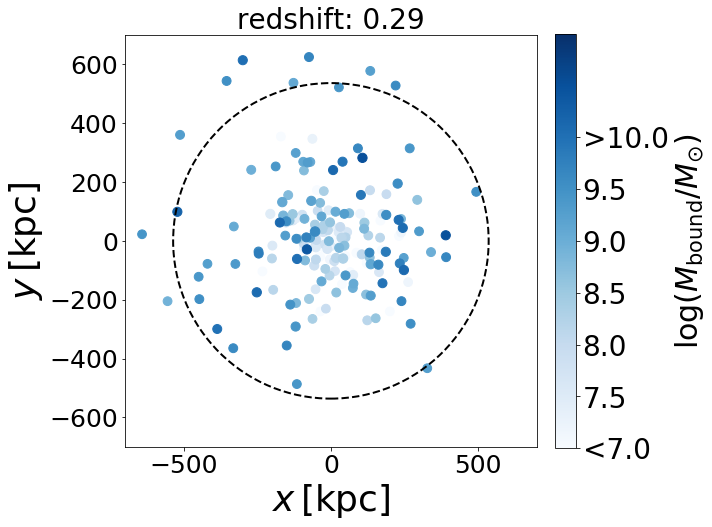

12.821283969629112


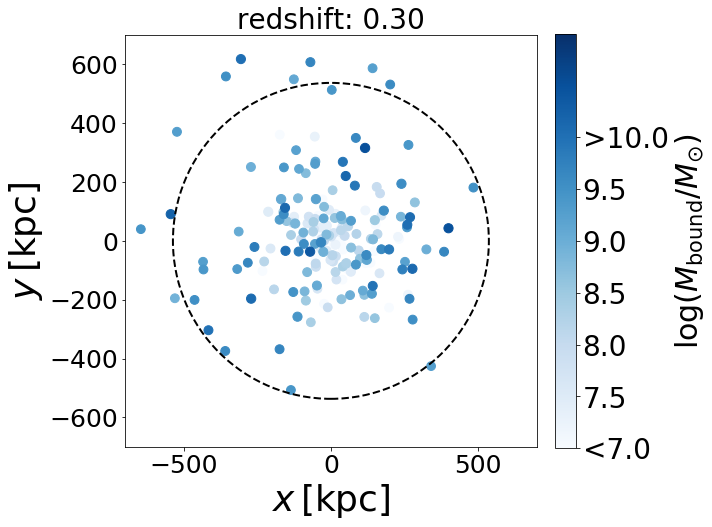

12.817449123598676


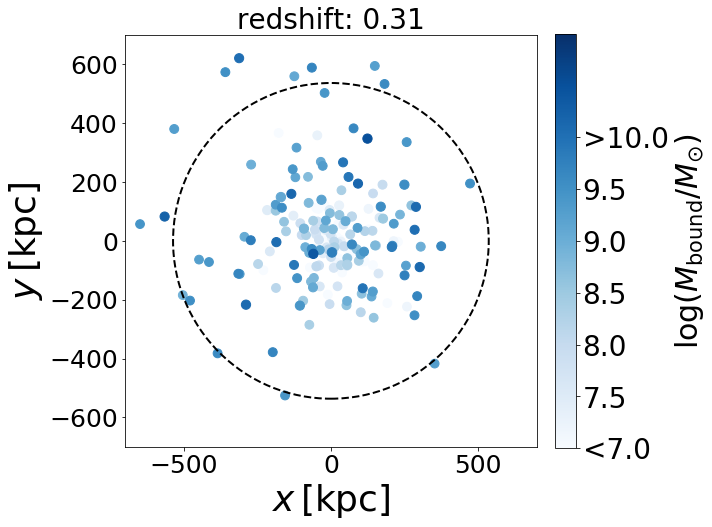

12.816252277011666


KeyboardInterrupt: 

In [43]:
redshift = 0.0

for i in range(450):
    curr=450-i-1
    #simulationNum, paramFilePath = genParameterFile(templateFilePath, directoryPath, haloMassList, replicationCount, massResolution, redshift, curr)

    #os.system( "./Galacticus.exe " + paramFilePath)

    outputFilePath = directoryPath + '/halo_mass_output_' + str(curr) + '.hdf5'
    halo = readGalacticusData.halo(outputFilePath, redshift, 1)
    visualize_subhalos(halo, 8, redshift, curr)
    
    redshift += 0.01

11.831922318483032


/central/software/python/3.7.0/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


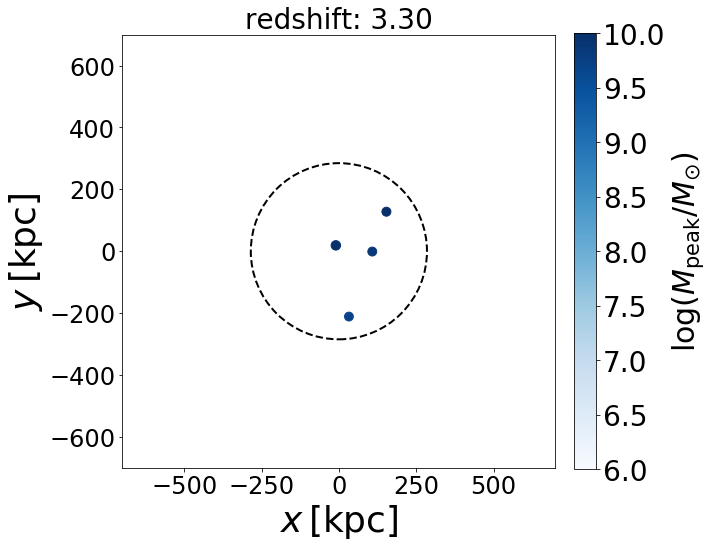

12.297168918826992


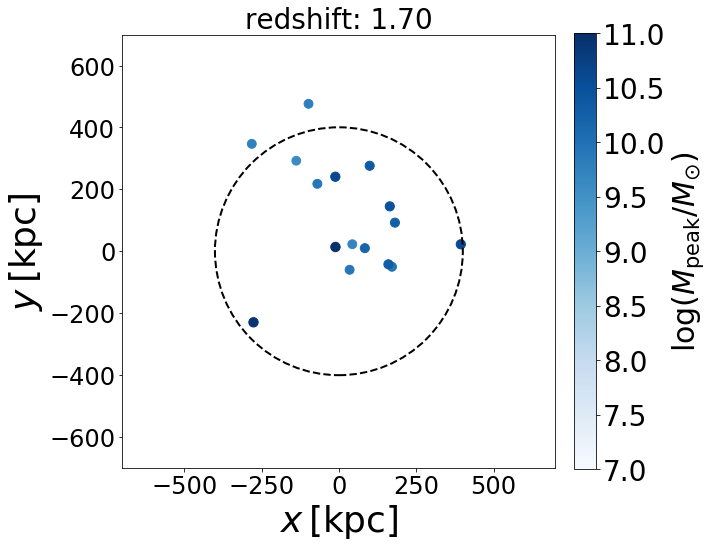

13.0


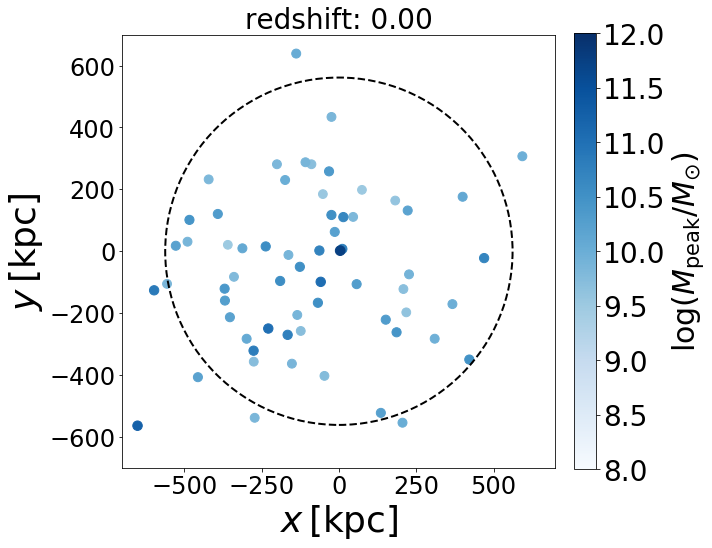

In [29]:
#TEST CODE FOR VISUJALIZATIONS.

outputFilePath = 'CASSI/week10/shifting_axes_360/halo_data3/halo_mass_output_23.hdf5'
halo = readGalacticusData.halo(outputFilePath, 3.3, 1)
visualize_subhalos(halo, 8, curr, 3.3)

outputFilePath = 'CASSI/week10/shifting_axes_360/halo_data3/halo_mass_output_55.hdf5'
halo = readGalacticusData.halo(outputFilePath, 1.7, 1)
visualize_subhalos(halo, 8, curr, 1.7)

outputFilePath = 'CASSI/week10/shifting_axes_360/halo_data3/halo_mass_output_89.hdf5'
halo = readGalacticusData.halo(outputFilePath, 0.0, 1)
visualize_subhalos(halo, 8, curr, 0.0)

In [ ]:
# Visualizations from 10^1 ... 10^10.

redshift = 0.0

for i in range(100):
    outputFilePath = 'CASSI/week10/halo_mass_output_' + str(i) + '.hdf5'
    redshift += 0.1
    replica = 1
    scaleFactor = 25
    halo = readGalacticusData.halo(outputFilePath, redshift, replica)
    visualize_subhalos(halo, scaleFactor, i)